# Sampling SDF with PyVista
 - SDF: signed distance function(or field)
 - https://en.wikipedia.org/wiki/Signed_distance_function
 - orthogonal distance of a given point x to the boundary of a set Ω in a metric space, with the sign determined by whether or not x is in the interior of Ω.
 - 임의의 점 x에 대해 경계로부터의 거리를 의미. 점 위치의 안/밖 구분에 따라 부호를 붙임(내부라면 +, 외부라면 -)
 - 정규화된 공간(점들을 등간격으로 공간에 배치 한 것:cubic grid)에서 SDF를 구하는 것을 SDF Grid Sampling 이라고 함
 - SDF Grid Sampling 은 생성형 모델의 입/출력으로 사용됨

In [30]:
import pyvista as pv
import vtk
import numpy as np

In [31]:
pv.global_theme.jupyter_backend = 'static'

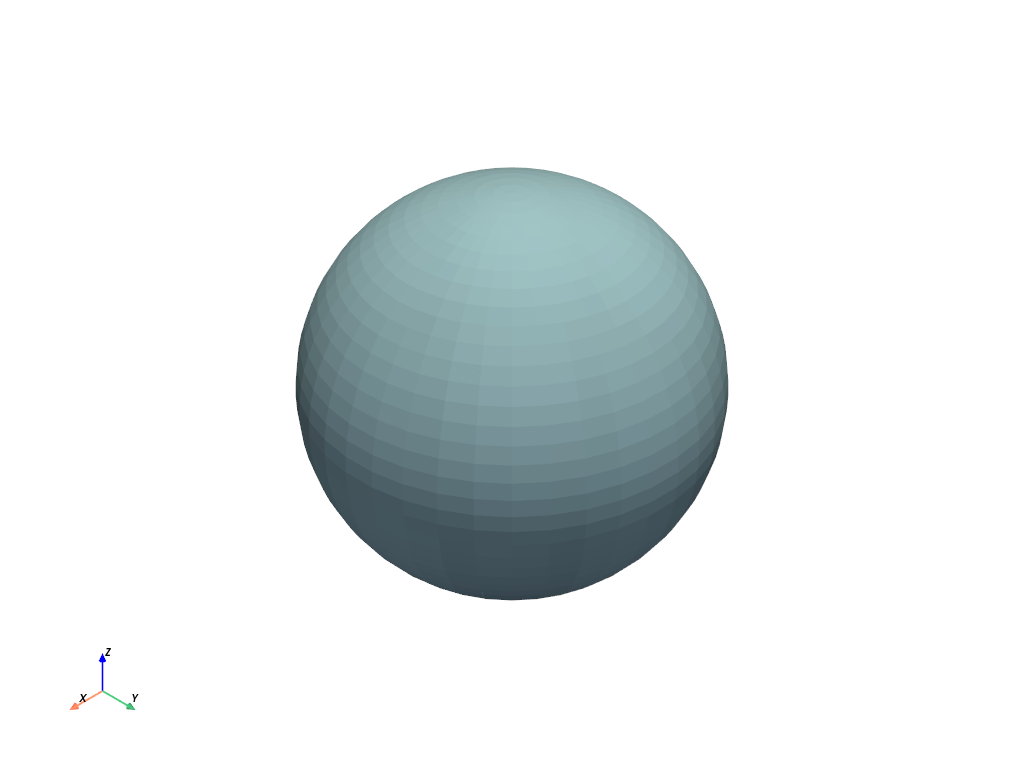

In [32]:
mesh = pv.Sphere(phi_resolution=40, theta_resolution=40)
mesh.plot()

In [33]:
resolution = 50
xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds

margin = 0.1
x_vals = np.linspace(xmin - margin, xmax + margin, resolution)
y_vals = np.linspace(ymin - margin, ymax + margin, resolution)
z_vals = np.linspace(zmin - margin, zmax + margin, resolution)

grid = pv.ImageData(dimensions=(resolution, resolution, resolution))
# grid.origin = (0.0, 0.0, 0.0)
# grid.spacing = (1.0, 1.0, 1.0)
grid.origin = (xmin, ymin, zmin)
grid.spacing = (x_vals[1] - x_vals[0], y_vals[1] - y_vals[0], z_vals[1] - z_vals[0])
# grid.point_data['points'] = grid_points
# grid.set_active_scalars('points')
grid

ImageData,Information
N Cells,117649
N Points,125000
X Bounds,"-4.996e-01, 6.996e-01"
Y Bounds,"-4.996e-01, 6.996e-01"
Z Bounds,"-5.000e-01, 7.000e-01"
Dimensions,"50, 50, 50"
Spacing,"2.447e-02, 2.447e-02, 2.449e-02"
N Arrays,0


# PyVista 의 compute_implicit_distance 로 SDF 구하기

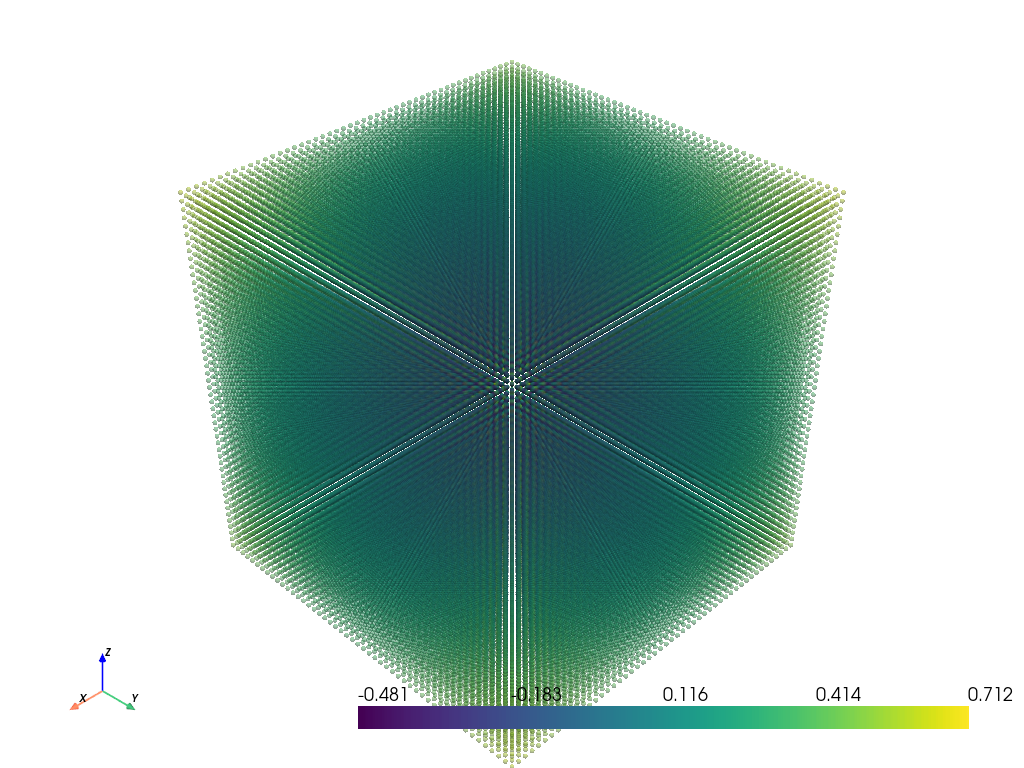

In [34]:
# PyVista의 SDF 계산이 trimesh 보다 훨씬 빠르다
sdf_grid = grid.compute_implicit_distance(surface=mesh)
sdf_grid.set_active_scalars('implicit_distance')
#sdf_grid.plot() # mesh 로 렌더링하기
pv.plot(
    sdf_grid.points,
    scalars=sdf_grid.point_data['implicit_distance'],
    render_points_as_spheres=True,
    point_size=5,
    show_scalar_bar=True,
    opacity=0.5,
)

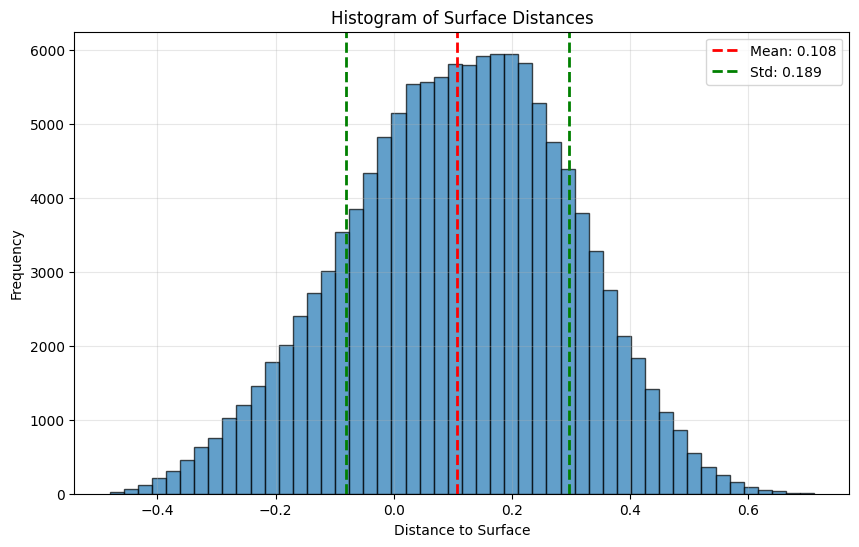

Mean distance: 0.108
Standard deviation: 0.189
Min distance: -0.481
Max distance: 0.712


In [35]:
from pvn import plot_histogram
plot_histogram(sdf_grid.point_data['implicit_distance'])

# SDF Grid 에서 다시 Mesh 로 복원하기
 - 점들의 집합에서 다시 surface mesh를 생성하는 것을 Contouring 이라고 함
 - Marching Cube, Dual Contouring 등 다양한 알고리즘 존재

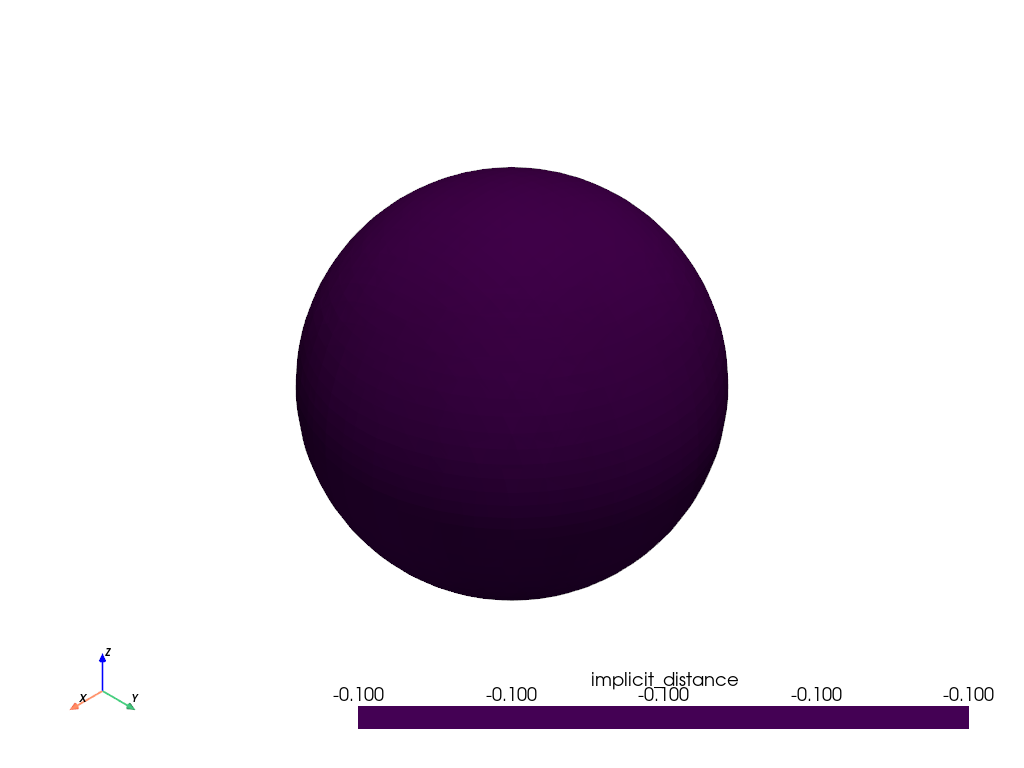

In [36]:
surface = sdf_grid.contour(isosurfaces=1, scalars='implicit_distance', rng=[-0.1, 0.1], method='marching_cubes')
surface.plot()

In [37]:
help(sdf_grid.contour)

Help on method contour in module pyvista.core.filters.data_set:

contour(isosurfaces=10, scalars=None, compute_normals=False, compute_gradients=False, compute_scalars=True, rng=None, preference='point', method='contour', progress_bar=False) method of pyvista.core.grid.ImageData instance
    Contour an input self by an array.
    
    ``isosurfaces`` can be an integer specifying the number of
    isosurfaces in the data range or a sequence of values for
    explicitly setting the isosurfaces.
    
    Parameters
    ----------
    isosurfaces : int | sequence[float], optional
        Number of isosurfaces to compute across valid data range or a
        sequence of float values to explicitly use as the isosurfaces.
    
    scalars : str | array_like[float], optional
        Name or array of scalars to threshold on. If this is an array, the
        output of this filter will save them as ``"Contour Data"``.
        Defaults to currently active scalars.
    
    compute_normals : bool, de